In [1]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import torch
from sklearn.metrics import confusion_matrix, classification_report
from pathlib import Path
import os
import numpy as np
from numpy import expand_dims
import cv2
import nibabel as nib
import matplotlib.pyplot as plt
import glob
import pandas as pd
from pathlib import Path
from google.colab import drive
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from skimage.color import gray2rgb
from sklearn.utils import shuffle
from skimage.transform import resize
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 20.3 MB/s eta 0:00:00


In [3]:
import pydicom

Because we are working on data stored in Google Cloud Storage bucket, the following steps will need to be taken:

Install gcsfuse it is a package used to mount the cloud bucket on to your local environment.

Authenticate your google account

Create a new directory to mount the storage bucket

Use gcsfuse to mount the storage bucket

You can browse throught the storage bucket here

In [4]:
!apt-get update -y && apt-get install -y fuse lsb-release; \
    curl -L -O https://github.com/GoogleCloudPlatform/gcsfuse/releases/download/v0.41.12/gcsfuse_0.41.12_amd64.deb; \
    dpkg --install gcsfuse_0.41.12_amd64.deb; \
    apt-get update; \
    apt-get clean;

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,194 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,627 kB]
Get:13 https://r2u.stat.illinois.edu/u

In [5]:
from google.colab import auth
auth.authenticate_user()

In [6]:
project_id = 'sfsu-378805'
bucket_name = 'csc-509-image-files'
!gcloud config set project {project_id}

Are you sure you wish to set property [core/project] to sfsu-378805?

Do you want to continue (Y/n)?  y

Updated property [core/project].


In [7]:
!gsutil ls

You are attempting to access protected data with no configured
credentials. Please visit https://cloud.google.com/console#/project
and sign up for an account, and then run the "gcloud auth login"
command to configure gsutil to use these credentials.


In [8]:
!mkdir images

In [9]:
!gcsfuse --implicit-dirs csc-509-image-files images

2024/12/11 04:39:25.835105 Start gcsfuse/0.41.12 (Go version go1.18.4) for app "" using mount point: /content/images
2024/12/11 04:39:25.853942 Opening GCS connection...
2024/12/11 04:39:26.306356 Mounting file system "csc-509-image-files"...
2024/12/11 04:39:26.307447 File system has been successfully mounted.


In [10]:
DATA_PATH = Path('/content/images/Module2_ADNI/')

In [11]:
data_df = pd.read_csv(Path(DATA_PATH,'CSVS/ADNI_AMYPet_withClinicalData_01122023.csv'))
data_df = data_df[data_df['SLICE_NUM'] == 48].reset_index(drop = True)
print(len(data_df))
data_df.head()

445


Unnamed: 0                             FILEPATH_MIDDLE_SLICES  SLICE_NUM  \
0           0  images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...         48   
1           1  images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...         48   
2           2  images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...         48   
3           3  images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...         48   
4           4  images/Module2_ADNI/PET_1/003_S_4288/AV45_Core...         48   

                                         AMYPET_TYPE     Subject  \
0  AV45_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_...  002_S_4447   
1  AV45_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_...  002_S_4447   
2  AV45_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_...  002_S_4447   
3  AV45_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_...  002_S_4447   
4  AV45_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_...  003_S_4288   

  Image Data ID Group Sex  Age  Visit Modality  \
0       I285198  EMCI   F   68     23      PET   
1       I285200  EMCI   F   68     23      PET   
2       I285197  EMCI   F   68     23      PET   
3       I285199  EMCI   F   68     23      PET   
4       I272168    CN   F   73     23      PET   

                                         Description       Type    Acq Date  \
0  AV45 Coreg, Avg, Std Img and Vox Siz, Uniform ...  Processed   2/13/2012   
1                         AV45 Co-registered Dynamic  Processed   2/13/2012   
2  AV45 Coreg, Avg, Standardized Image and Voxel ...  Processed   2/13/2012   
3                       AV45 Co-registered, Averaged  Processed   2/13/2012   
4  AV45 Coreg, Avg, Standardized Image and Voxel ...  Processed  12/06/2011   

  Format Downloaded  
0    DCM  9/16/2021  
1    DCM  9/16/2021  
2    DCM  9/16/2021  
3    DCM  9/16/2021  
4    DCM  9/16/2021

In [12]:
data_df['FOLDERPATH_MIDDLE_SLICES'] = data_df['FILEPATH_MIDDLE_SLICES'].str.rsplit('/', n = 1).str[0]
data_df['Group'].unique()

array(['EMCI', 'CN', 'AD', 'LMCI', 'SMC', 'MCI'], dtype=object)

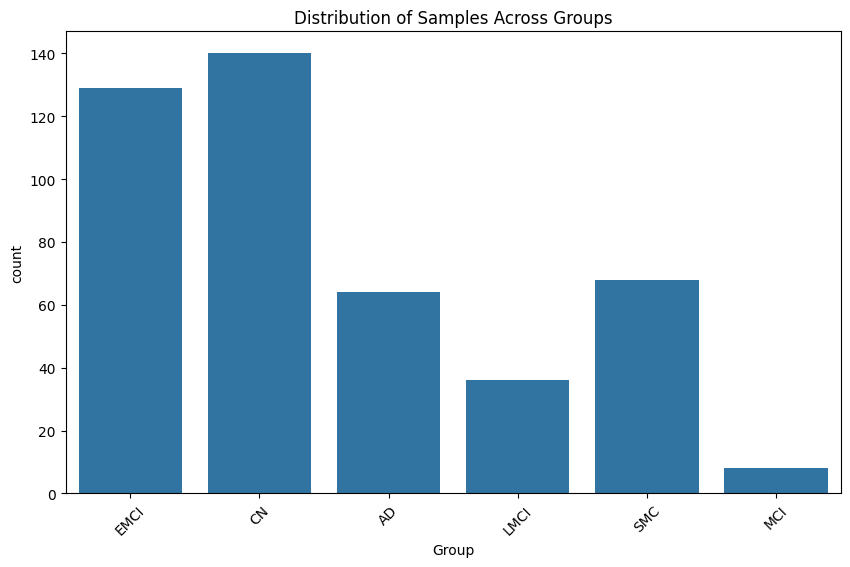

In [13]:
# Bar plot of group distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=data_df, x='Group')
plt.title('Distribution of Samples Across Groups')
plt.xticks(rotation=45)
plt.show()

- CN : Cognitively normal
- MCI : Mild cognitive impairment
- EMCI : Early mild cognitive impairment
- LMCI: Late mild cognitive impairment
- AD : Alzheimer's disease
- SMC : Significant memory concerns


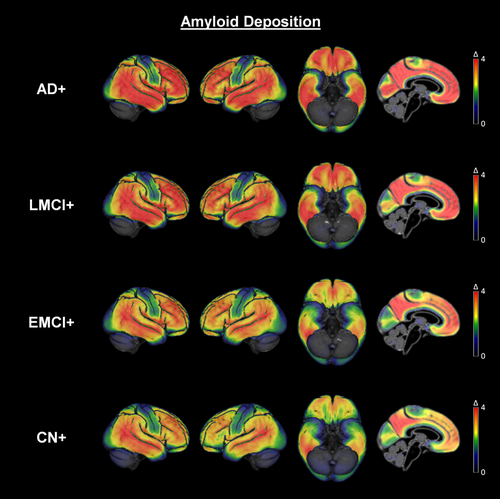



In [15]:
# We will train a binary classifier for CN v/s AD, so let's filter for these values of the column Group.
data_df = data_df[['Image Data ID', 'FILEPATH_MIDDLE_SLICES', 'FOLDERPATH_MIDDLE_SLICES', 'Group' ]]
data_df_filt = data_df[data_df['Group'].isin(['AD', 'CN', 'EMCI'])].reset_index(drop = True)


print("Number of patient ids:", len(data_df_filt))
data_df_filt.head()

Number of patient ids: 333


Image Data ID                             FILEPATH_MIDDLE_SLICES  \
0       I285198  images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...   
1       I285200  images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...   
2       I285197  images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...   
3       I285199  images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...   
4       I272168  images/Module2_ADNI/PET_1/003_S_4288/AV45_Core...   

                            FOLDERPATH_MIDDLE_SLICES Group  
0  images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...  EMCI  
1  images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...  EMCI  
2  images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...  EMCI  
3  images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...  EMCI  
4  images/Module2_ADNI/PET_1/003_S_4288/AV45_Core...    CN

In [16]:
# Let's check the number of patients with CN and AD
data_df_filt[['Image Data ID', 'Group']].groupby(by = 'Group').count()

Image Data ID
Group               
AD                64
CN               140
EMCI             129

In [17]:
# Split into training, validation set and test set
ids = data_df_filt['Image Data ID'].unique()

# Here we have selected the size of test set as 15 %
train_ids, test_ids = train_test_split(ids,test_size=0.15)

# Create validation ids by further splitting the train ids, we again use 15 % as size of validation set. Validation set is also referred to as tuning set.
train_ids, val_ids = train_test_split(train_ids,test_size=0.15)

In [18]:
# Let's check the number of patients ids in train, validation and test set
print(f'There are {len(train_ids)} patient ids in training set')
print(f'There are {len(val_ids)} patient ids in validation set')
print(f'There are {len(test_ids)} patient ids in test set')

There are 240 patient ids in training set
There are 43 patient ids in validation set
There are 50 patient ids in test set


In [19]:
# Let's check the number of CN and AD patients in the splits. We want our splits to be balanced.
data_df_filt['Split'] = np.where(data_df_filt['Image Data ID'].isin(train_ids), 'Train', '')
data_df_filt['Split'] = np.where(data_df_filt['Image Data ID'].isin(val_ids), 'Validation', data_df_filt['Split'])
data_df_filt['Split'] = np.where(data_df_filt['Image Data ID'].isin(test_ids), 'Test', data_df_filt['Split'])

data_df_filt[['Image Data ID', 'Group', 'Split']].groupby(by = ['Split', 'Group']).count()

Image Data ID
Split      Group               
Test       AD                 8
           CN                23
           EMCI              19
Train      AD                45
           CN                99
           EMCI              96
Validation AD                11
           CN                18
           EMCI              14

In [20]:
def normalize(image, label, percentile = 0.001,
              eps = 0.0000001):


    img_array = np.ndarray.flatten(image)
    min_img, max_img = np.quantile(img_array, percentile), np.quantile(img_array, 1-percentile)
    img_normalized = ((image-min_img)/(max_img-min_img+eps)*255).astype(np.uint8)
    input_image = torch.tensor(img_normalized, dtype=torch.float32)/255

    if label == 'CN':
      input_label = 0
    elif label == 'EMCI':
      input_label = 1
    elif label == 'AD':
        input_label = 2
    else:
        raise ValueError(f"Unexpected label: {label}")


    return input_image, input_label

In [21]:
def read_all_dicom_slices(dicom_directory):
    """
    Will read in the images from a single dicom folder and return a dictionary of
    those images with the key as the presumed slice number, and the value being the pixel array.

    dicom_directory: Path or string that leads to the folder containing the slices

    """
    dicom_image_dict = {}
    for image in glob.glob(str(Path(dicom_directory, '*'))):
      key = image.split('/')[-1].split('_')[-3]
      dicom_image_dict[key]= pydicom.dcmread(image)
    return dicom_image_dict

In [22]:
def create_numpy_array(df):
  X = []
  Y = []
  for i in range(len(df)):
    print("i:"+ str(i))
    dicom_volume = read_all_dicom_slices(df['FOLDERPATH_MIDDLE_SLICES'][i])
    print(dicom_volume)
    keys_sorted = [str(x) for x in sorted([int(x) for x in list(dicom_volume.keys())])]
    print(keys_sorted)
    keys_filt = [46, 47, 48, 49, 50] # picks up 5 slices per image
    for key in keys_filt: # iterates through the dictionary, while the enumerate function keeps track of the index with j
        value = dicom_volume[str(key)]
        image = value.pixel_array
        label = df['Group'][i]
        new_image, new_label = normalize(image, label)
        X.append(new_image)
        Y.append(new_label)
  return np.asarray(X), np.asarray(Y)

In [23]:
#Let's create numpy arrays for training, validation and test sets using the above 3 functions
X_train, Y_train = create_numpy_array(data_df_filt[data_df_filt['Split'] == 'Train'].reset_index(drop = True))
X_val, Y_val = create_numpy_array(data_df_filt[data_df_filt['Split'] == 'Validation'].reset_index(drop = True))
X_test, Y_test = create_numpy_array(data_df_filt[data_df_filt['Split'] == 'Test'].reset_index(drop = True))

Streaming output truncated to the last 5000 lines.
   ---------
(0054,0016)  Radiopharmaceutical Information Sequence  1 item(s) ---- 
   (0018,0031) Radiopharmaceutical                 LO: 'AV45'
   ---------
(0054,0081) Number of Slices                    US: 96
(0054,0101) Number of Time Slices               US: 1
(0054,1000) Series Type                         CS: ['STATIC', 'IMAGE']
(0054,1001) Units                               CS: 'NONE'
(0054,1002) Counts Source                       CS: 'EMISSION'
(0054,1100) Randoms Correction Method           CS: 'SING'
(0054,1101) Attenuation Correction Method       LO: 'measured,, 0.096000 cm-1,'
(0054,1103) Reconstruction Method               LO: '3D IR'
(0054,1105) Scatter Correction Method           LO: 'Model Based'
(0054,1200) Axial Acceptance                    DS: ''
(0054,1201) Axial Mash                          IS: [1, 2]
(0054,1202) Transverse Mash                     IS: '2'
(0054,1300) Frame Reference Time                DS: 

In [ ]:
# Let's save the train, validation and test arrays to a path in your drive
np.save('/content/drive/MyDrive/Numpy_ADNI/AmyPET_train_images.npy', X_train) # Enter the path where you will save the file
np.save('/content/drive/MyDrive/Numpy_ADNI/AmyPET_val_images.npy', X_val)
np.save('/content/drive/MyDrive/Numpy_ADNI/AmyPET_test_images.npy', X_test)
np.save('/content/drive/MyDrive/Numpy_ADNI/AmyPET_train_label.npy', Y_train)
np.save('/content/drive/MyDrive/Numpy_ADNI/AmyPET_val_label.npy', Y_val)
np.save('/content/drive/MyDrive/Numpy_ADNI/AmyPET_test_label.npy', Y_test)

In [25]:
# Converting grayscale images to RGB
X_train = np.array([gray2rgb(X_train[i]) for i in range(len(X_train))])
X_val = np.array([gray2rgb(X_val[i]) for i in range(len(X_val))])
X_test = np.array([gray2rgb(X_test[i]) for i in range(len(X_test))])

In [26]:
X_train, Y_train = shuffle(X_train, Y_train, random_state = 0)
X_val, Y_val = shuffle(X_val, Y_val, random_state = 0)
X_test, Y_test = shuffle(X_test, Y_test, random_state = 0)

In [27]:
# Let's confirm the size of the training and validation arrays
print(f'There are {len(X_train)} images in training set')
print(f'There are {len(X_val)} images in validation set')
print(f'There are {len(X_test)} images in test set')

There are 1200 images in training set
There are 215 images in validation set
There are 250 images in test set


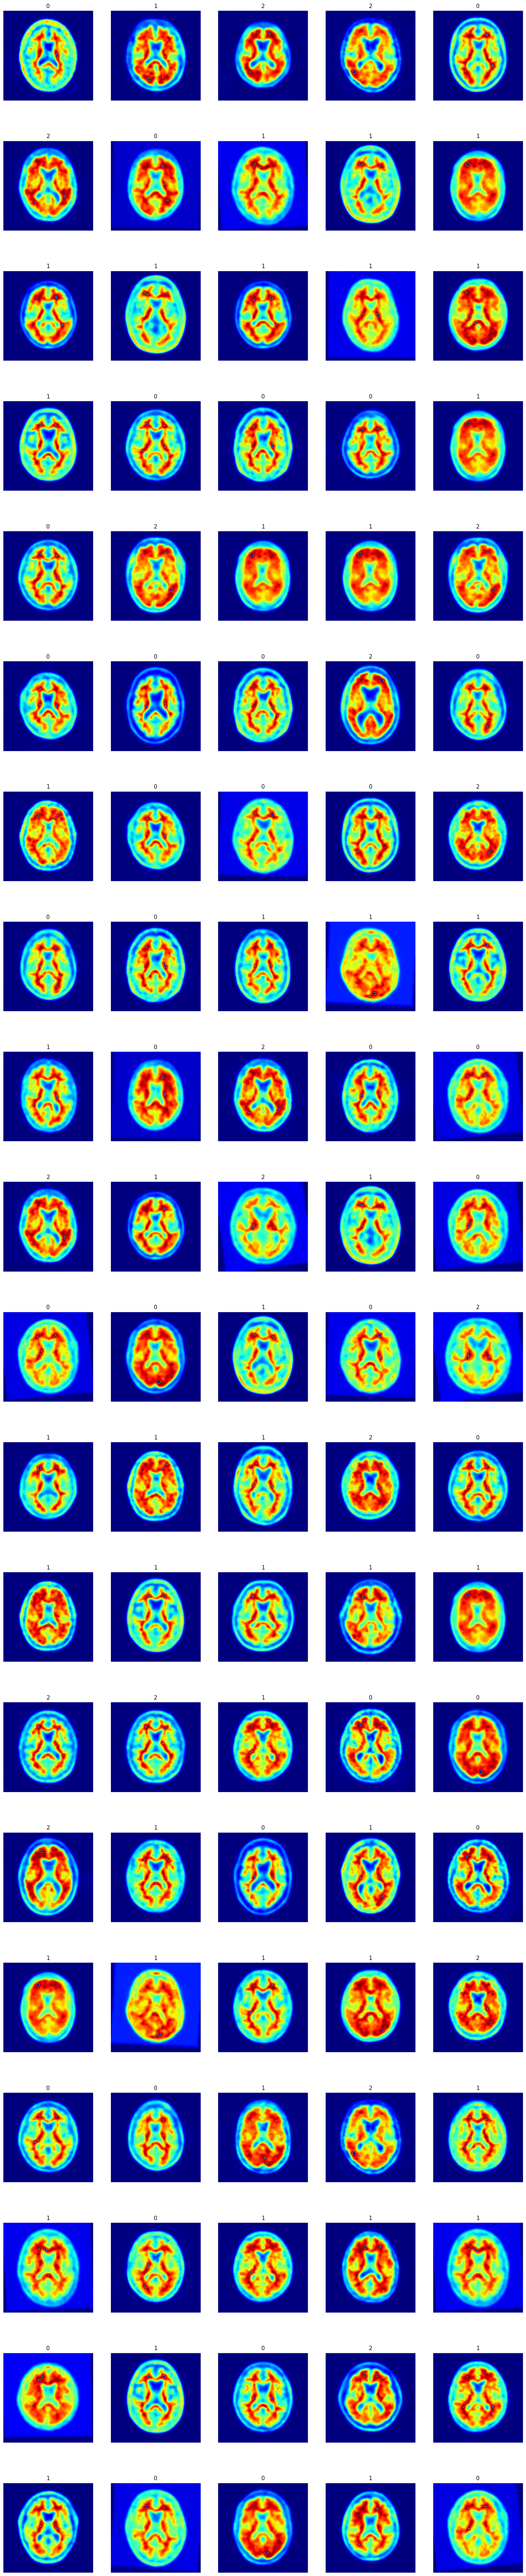

In [28]:
plt.figure(figsize = (20, 100))
for i in range(100):

    plt.subplot(20,5, i+1)
    plt.imshow(X_train[i][:,:,0], cmap = 'jet')
    plt.axis('off')
    plt.title(Y_train[i])